In [1]:
"""DMD with Control vs Deep Recurrent Koopman (DeReK) comparison for non-linear systems"""

import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp

# Add parent directory to path
sys.path.append(os.path.dirname(os.getcwd()))

from functions.dmd import DMDc
from functions.plot import set_size
from functions.preprocessing import time_shift

%load_ext autoreload
%autoreload 2

# Set random seed for reproducibility
np.random.seed(42)


part = 1000

results_path = "results/.dmdc/"
if not os.path.exists(results_path):
    os.makedirs(results_path)


def mae(Y: np.ndarray, Y_pred: np.ndarray) -> np.ndarray:
    return np.mean(np.abs(Y - Y_pred), axis=0)


def sad(Y: np.ndarray, Y_pred: np.ndarray) -> np.ndarray:
    return np.sum(np.abs(Y - Y_pred), axis=0)


# Set preprocessing parameters
residuals = False
sqrt = True
degree = 2
hm = 20  # orig 20
hl = 0
p = 0
q = 0
# Import train data
train_data = pd.read_pickle("data/train_sim.pkl")
# noise = np.zeros(train_data["X"].shape)
X: np.ndarray = (train_data["X"])[:-1]
U: np.ndarray = train_data["U"][:-1]
# We want Y_k to be X_{k+1}
Y: np.ndarray = (train_data["Y"])[1:]
n, m = X.shape
# Import test data
test_data = pd.read_pickle("data/test_sim.pkl")
X_t: np.ndarray = (test_data["X"])[:-1]
U_t: np.ndarray = test_data["U"][:-1]
Y_t: np.ndarray = (test_data["Y"])[1:]
# Import DeReK results
data_derek = sp.io.loadmat("../results/pred_sim_DeReK.mat")
start = 80
y_pred_derek_h1 = data_derek["h1"]
y_pred_derek_h2 = data_derek["h2"]
Y_pred_derek = np.vstack((y_pred_derek_h1, y_pred_derek_h2)).T[: part - hm]

# Extract non-linear features
basis_functions = [
    lambda x: x**2,
    lambda x: x**3,
    lambda x: x,
]
inv_basis_functions = [
    lambda x: np.sqrt(x),
    lambda x: x ** (1 / 3),
    lambda x: x,
]
X = np.hstack([f(X) for f in basis_functions])
# Extract time-delayed features
X = time_shift(X, hm)
U = U[:-hm]
Y = Y[:-hm]

X_t = np.hstack([f(X_t) for f in basis_functions])
X_t = time_shift(X_t, hm)[start : start + part]
U_t = U_t[start : start + part - hm]
Y_t = Y_t[start : start + part - hm]

# Set parameters
pred_step = len(Y_t)

# Train DMD model
model = DMDc(p=p, q=q)
model.fit(X, U=U)

In [2]:
Y_pred = model.predict(X[0, :], U=U, forecast=len(Y))
stats_ = {
    "MAE": [],
    "SAD": [],
}
for j in range(0, hm * len(basis_functions), m * len(basis_functions)):
    for i, fun in enumerate(inv_basis_functions):
        start_col = i * m + j
        end_col = (i + 1) * m + j
        Y_pred[:, start_col:end_col] = fun(Y_pred[:, start_col:end_col])
        stats_["MAE"].append(mae(Y, Y_pred[:, start_col:end_col]).sum())
        stats_["SAD"].append(sad(Y, Y_pred[:, start_col:end_col]).sum())

/var/folders/r5/m56sdg656cj3mp06q32vtxrw0000gn/T/ipykernel_92507/2686097868.py:75: RuntimeWarning: invalid value encountered in sqrt
  lambda x: np.sqrt(x),
/var/folders/r5/m56sdg656cj3mp06q32vtxrw0000gn/T/ipykernel_92507/2686097868.py:76: RuntimeWarning: invalid value encountered in power
  lambda x: x ** (1 / 3),


In [3]:
# Index of best matching transformation to original data
best_idx = np.nanmin(stats_["MAE"])
best_idx = stats_["MAE"].index(best_idx)
best_idx

2

/var/folders/r5/m56sdg656cj3mp06q32vtxrw0000gn/T/ipykernel_92507/2686097868.py:75: RuntimeWarning: invalid value encountered in sqrt
  lambda x: np.sqrt(x),
/var/folders/r5/m56sdg656cj3mp06q32vtxrw0000gn/T/ipykernel_92507/2686097868.py:76: RuntimeWarning: invalid value encountered in power
  lambda x: x ** (1 / 3),


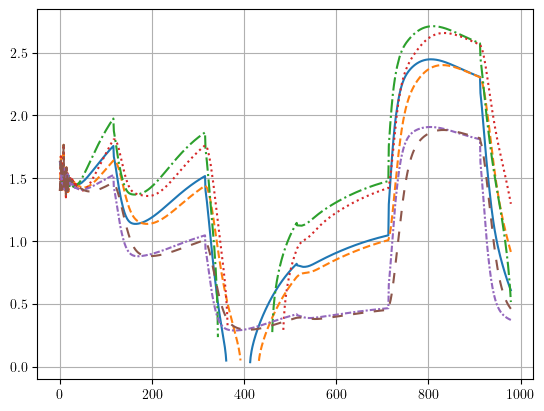

In [ ]:
# [donotremove]
Y_pred = model.predict(X_t[0, :], U=U_t, forecast=pred_step)
for j in range(0, hm * len(basis_functions), m * len(basis_functions)):
    for i, fun in enumerate(inv_basis_functions):
        start_col = i * m + j
        end_col = (i + 1) * m + j
        Y_pred[:, start_col:end_col] = fun(Y_pred[:, start_col:end_col])
_ = plt.plot(Y_pred[:, : m * len(basis_functions)])
Y_pred = Y_pred[:, best_idx * m : (best_idx + 1) * m]

Model                 | MAE    | SAD
DeReK                 | 0.1847 | 181.04
eDMD w/o $\sqrt{x}$   | 0.6058 | 593.7


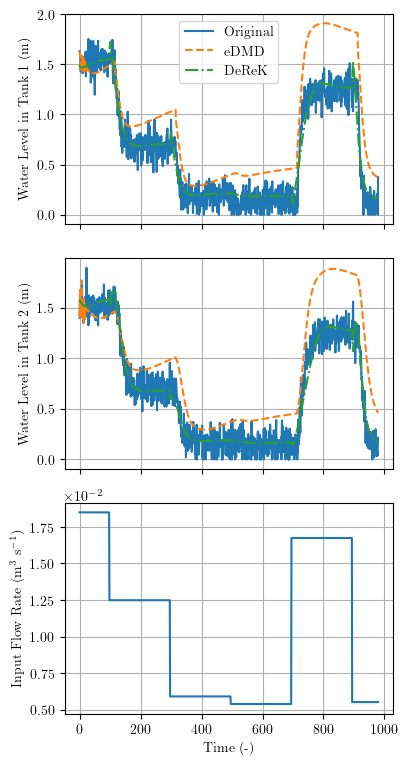

In [ ]:
# [donotremove]
# Print MAE and SAD
print("Model".ljust(21, " "), "| MAE    | SAD")
mae_ = mae(Y_t, Y_pred_derek)
sad_ = sad(Y_t, Y_pred_derek)
print(
    "DeReK".ljust(21, " "), "|", mae_.sum().round(4), "|", sad_.sum().round(2)
)
mae_ = mae(Y_t, Y_pred)
sad_ = sad(Y_t, Y_pred)
print(
    "eDMD w/o $\\sqrt{x}$".ljust(21, " "),
    "|",
    mae_.sum().round(4),
    "|",
    sad_.sum().round(2),
)

# Plot results
fig, axs = plt.subplots(
    3, 1, figsize=set_size("ieee", subplots=(3, 1)), sharex=True
)
if not isinstance(axs, np.ndarray):
    axs = np.array([axs])

for i, (ax, y_t, y_pred, y_derek) in enumerate(
    zip(axs, Y_t.T, Y_pred.T, Y_pred_derek.T), start=1
):
    ax.plot(y_t)
    ax.plot(y_pred)
    ax.plot(y_derek)
    ax.set_ylabel(f"Water Level in Tank {i} " + "$\\mathrm{(m)}$")
    ax.ticklabel_format(style="sci", axis="y", scilimits=(2, 1))

axs[2].plot(U_t[:, -1])
axs[2].set_ylabel("Input Flow Rate $\\mathrm{(m^3~s^{-1})}$")
axs[2].set_xlabel("Time (-)")
axs[2].ticklabel_format(style="sci", axis="y", scilimits=(2, 1))

axs[0].legend(["Original", "eDMD", "DeReK"])

fig.tight_layout()
fig.savefig(f"{results_path}dmdc_multipred-p{p}-q{q}-hm{hm}-hl{hl}.pdf")

In [8]:
sp.io.savemat(
    "results/pred_sim_eDMDc_wo_sqrt.mat", dict(zip(["h1", "h2"], Y_pred.T))
)

In [9]:
np.save("results/eig_eDMDc_wo_sqrt.npy", model.eig[0])
np.save("results/amplitudes_eDMDc_wo_sqrt.npy", model.xi)

In [ ]:
# [donotremove]
def controllability_test(A, B):
    """
    Test the controllability of a system given state-space matrices A and B.

    Parameters:
    A (ndarray): State matrix of size (n, n)
    B (ndarray): Input matrix of size (n, m)

    Returns:
    bool: True if the system is controllable, False otherwise.
    """
    n = A.shape[0]  # Number of states
    controllability_matrix = B

    # Compute [B, AB, A^2B, ..., A^(n-1)B]
    for i in range(1, n):
        controllability_matrix = np.hstack(
            (controllability_matrix, np.linalg.matrix_power(A, i) @ B)
        )

    # Check rank of the controllability matrix
    rank = np.linalg.matrix_rank(controllability_matrix)
    return rank == n


A = model.A
B = model.B

is_controllable = controllability_test(A, B)
print(f"System is controllable: {is_controllable}")


def analyze_controllability(A, B):
    n = A.shape[0]
    controllability_matrix = B
    for i in range(1, n):
        controllability_matrix = np.hstack(
            (controllability_matrix, np.linalg.matrix_power(A, i) @ B)
        )

    rank = np.linalg.matrix_rank(controllability_matrix)
    return controllability_matrix, rank


C_matrix, rank = analyze_controllability(A, B)
print("Controllability Matrix:")
print(C_matrix)
print(f"Rank: {rank}/{A.shape[0]}")

System is controllable: False
Controllability Matrix:
[[ 1.46081032e-14  4.82016923e-14  1.15741551e-13 ... -2.35536921e-01
  -2.56971339e-01 -2.77949493e-01]
 [ 1.86774197e-13  2.08097655e-14  2.08201377e-14 ...  4.68661741e-01
   4.34522210e-01  4.00910814e-01]
 [-1.02289408e-13  2.61581865e-13  1.38059225e-13 ... -4.99858368e-01
  -6.07452109e-01 -7.12973191e-01]
 ...
 [ 6.48087923e+00  1.08634016e+01  1.21466720e+01 ...  1.14813917e-01
   6.22712662e-04 -1.11354856e-01]
 [ 1.64218652e+01  3.47830096e+00  3.68518839e+00 ... -9.04554636e-02
  -9.22425243e-02 -9.39566321e-02]
 [ 2.05356378e+00  9.16568845e-01  1.19164219e+00 ... -1.20202271e-02
  -1.58692769e-02 -1.96242536e-02]]
Rank: 119/120
